In [53]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

In [42]:
targets = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

In [43]:
targets.head()

,date,station,target
0,2015-01-03,ES0691A,0
1,2015-01-03,ES1396A,0
2,2015-01-03,ES1438A,0
3,2015-01-03,ES1480A,0
4,2015-01-03,ES1679A,0


In [44]:
stations.head()

,code,name,lat,lon,height,city,country
0,ES1480A,Barcelona (Gràcia-Sant Gervasi),41.3987,2.15339,57,Barcelona,España
1,ES1856A,Barcelona (Vall d'Hebron),41.4261,2.14799,136,Barcelona,España
2,ES1679A,Ciutadella,41.3864,2.18742,7,Barcelona,España
3,ES1438A,Barcelona (Eixample),41.3853,2.15382,26,Barcelona,España
4,ES1396A,Barcelona,41.3788,2.13310,35,Barcelona,España


In [162]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        data['year'] = year
        data['station'] = station
        observations.append(data)
        
observations = pd.concat(observations)
observations = observations[[c for c in observations.columns if c not in [
    'Countrycode',
    'Namespace',
    'AirQualityNetwork',
    'AirQualityStation',
    'AirQualityStationEoICode',
    'SamplingPoint',
    'SamplingProcess',
    'AveragingTime',
    'UnitOfMeasurement',
    'AirPollutant',
    'AirPollutantCode',
    'Validity',
    'Verification',
    'DatetimeEnd',
    'year',
    'Sample'
]]]
observations['datetime'] = pd.to_datetime(observations['DatetimeBegin'])
observations = observations.drop('DatetimeBegin', axis=1)
observations = observations.sort_values('datetime')
observations['date'] = observations['datetime'].apply(lambda dt: dt.date())
observations['time'] = observations['datetime'].apply(lambda dt: dt.time())
observations.head(5)

,Concentration,station,datetime,date,time
8607,19,ES1992A,2013-01-01 01:00:00,2013-01-01,01:00:00
5770,54,ES1480A,2013-01-01 01:00:00,2013-01-01,01:00:00
3995,11,ES1856A,2013-01-01 01:00:00,2013-01-01,01:00:00
6895,39,ES1396A,2013-01-01 01:00:00,2013-01-01,01:00:00
2527,55,ES0691A,2013-01-01 01:00:00,2013-01-01,01:00:00


In [164]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models).sort_values(['day', 'hour'])
models = models[[c for c in models.columns if c not in [
    'AirPollutant',
    'year'
]]]
models['datetime'] = pd.to_datetime(models['day'].astype(str) + ' ' + models['hour'].astype(str))
models = models.sort_values('datetime', ascending=True)
models['date'] = models['datetime'].apply(lambda dt: dt.date())
models['time'] = models['datetime'].apply(lambda dt: dt.time())
models.head(5)

,lon,lat,day,hour,Concentration,station,datetime,date,time
0,2.20452,41.4039,2013-01-01,00:00:00,35.8472,ES0691A,2013-01-01,2013-01-01,00:00:00
0,2.18742,41.3864,2013-01-01,00:00:00,38.7881,ES1679A,2013-01-01,2013-01-01,00:00:00
0,2.15339,41.3987,2013-01-01,00:00:00,31.8140,ES1480A,2013-01-01,2013-01-01,00:00:00
0,2.15382,41.3853,2013-01-01,00:00:00,38.7881,ES1438A,2013-01-01,2013-01-01,00:00:00
0,2.11515,41.3875,2013-01-01,00:00:00,28.5303,ES1992A,2013-01-01,2013-01-01,00:00:00


In [179]:
observations.groupby(['station']).agg({
    'Concentration': ['mean', 'std', 'var', 'count']
})

Concentration                              
                 mean        std         var  count
station                                            
ES0691A     41.041319  23.278777  541.901469  22919
ES1396A     33.747620  21.847828  477.327583  22688
ES1438A     55.131554  25.452065  647.807589  22599
ES1480A     53.613499  27.370526  749.145685  22802
ES1679A     37.823535  23.731780  563.197397  23030
ES1856A     29.057570  22.203759  493.006923  22859
ES1992A     32.639648  24.233027  587.239574  22836

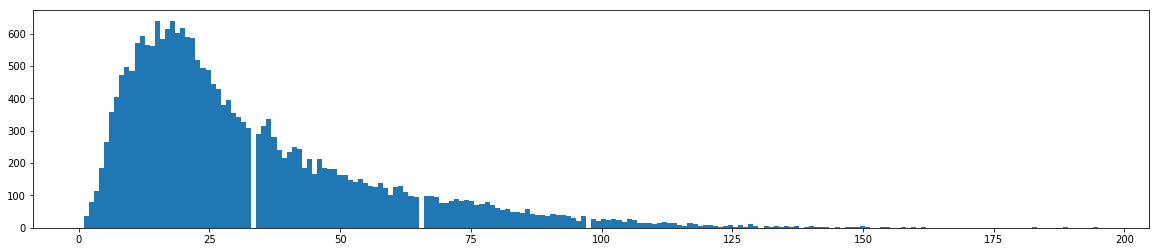

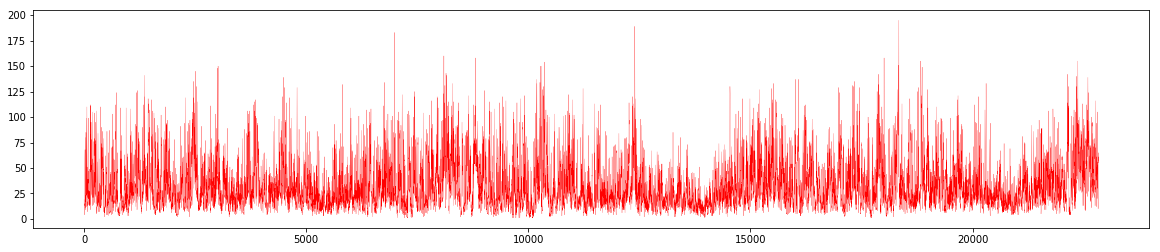

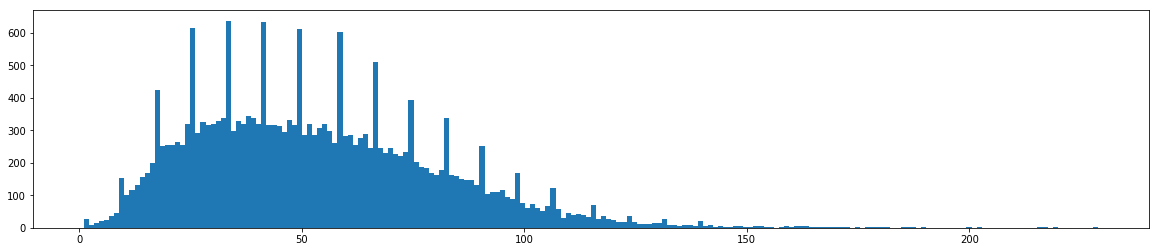

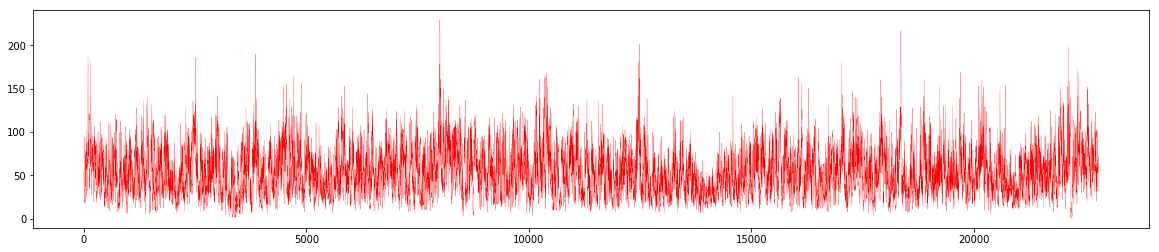

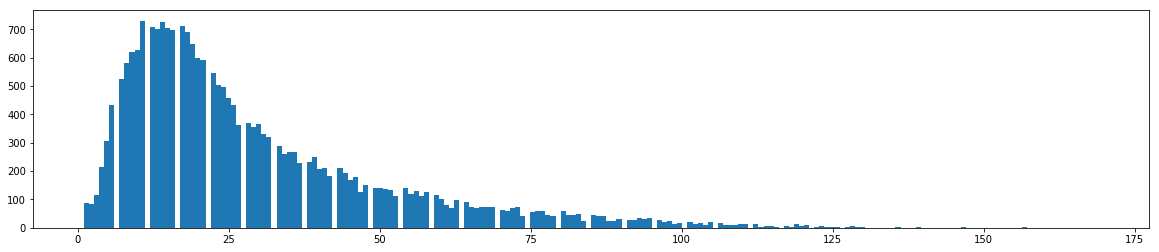

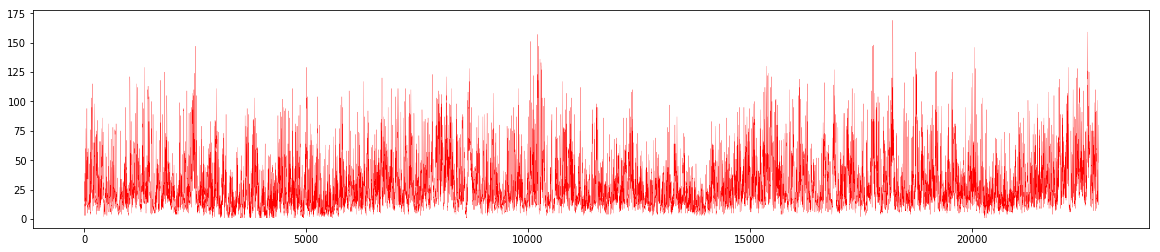

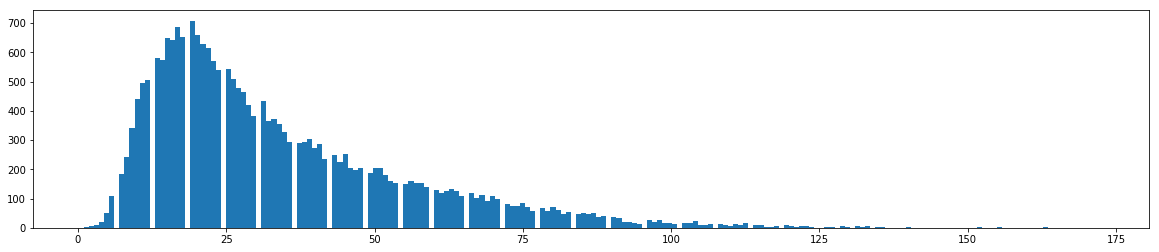

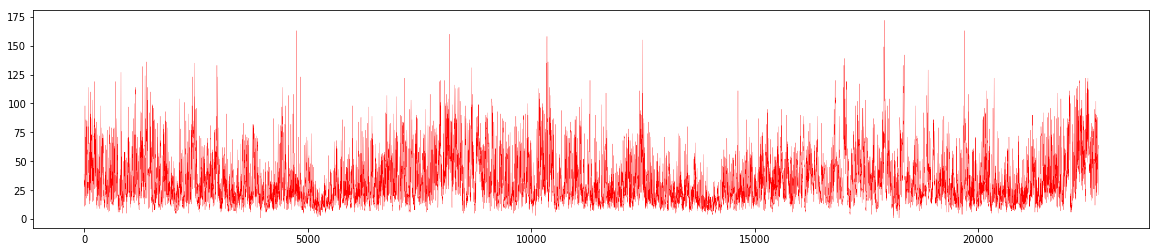

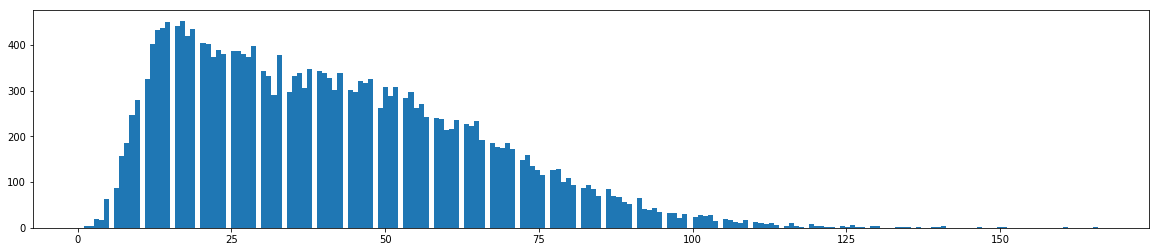

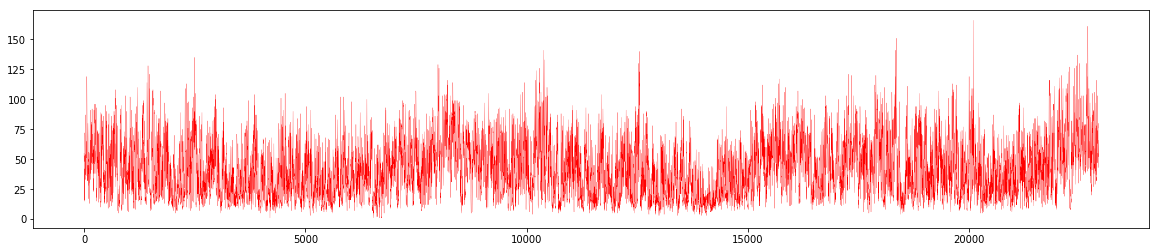

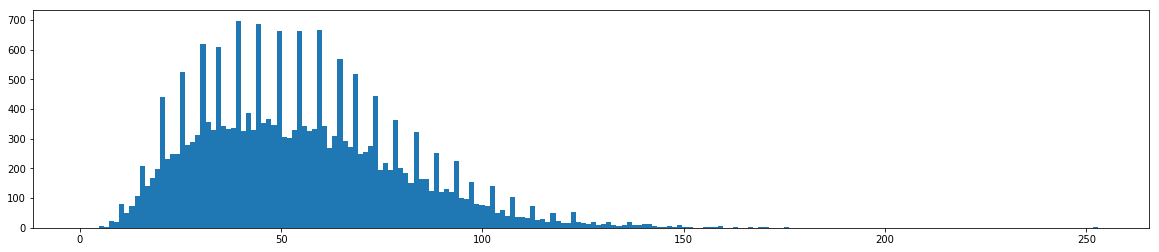

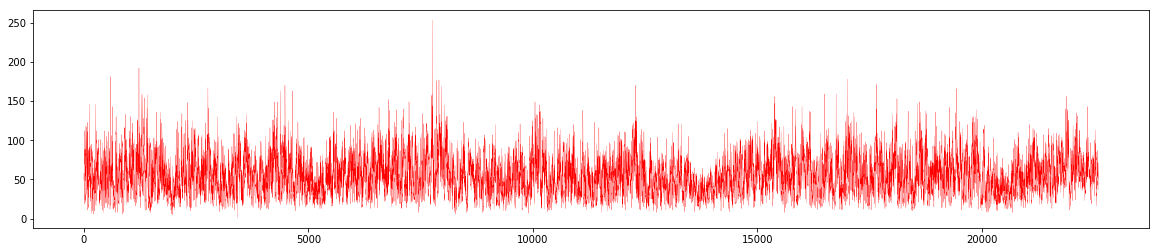

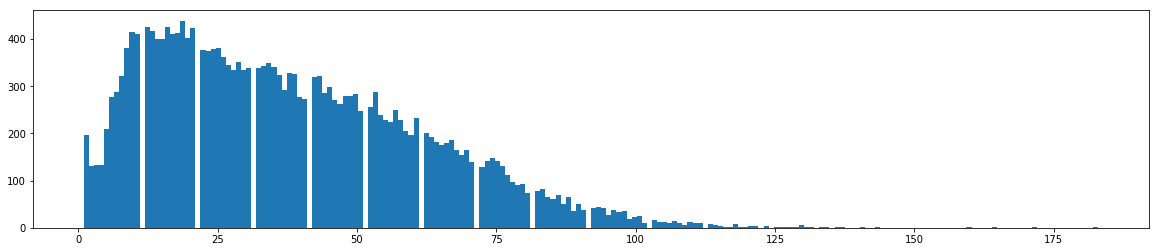

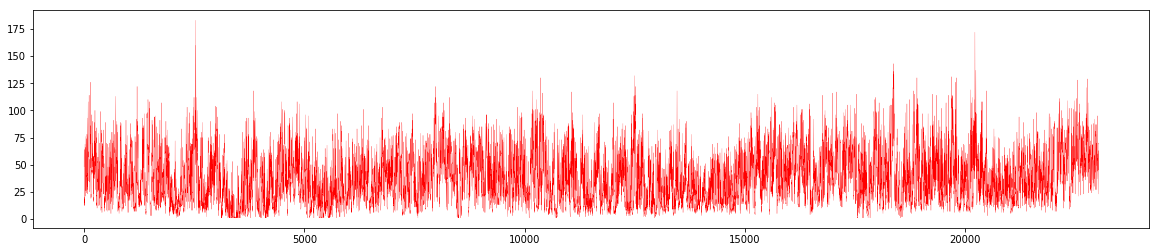

In [177]:
for s in observations['station'].unique():
    plt.figure(figsize=(20, 4))
    plt.hist(observations[observations['station'] == s]['Concentration'], bins=200)
    plt.figure(figsize=(20, 4))
    x_ax = list(range(0, observations[observations['station'] == s].shape[0]))
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'r-', lw=.2)